In [0]:
# -----------------------------
# CONFIG: change if needed
# -----------------------------
storage_account = "goodreadsreviews60302087"
container = "project"
raw_file = "raw/combined_counts_matrix.json"

account_fqdn = f"{storage_account}.dfs.core.windows.net"

# If you're using an account key (from the portal > Access keys)
# paste it into the Databricks secret scope or directly here (NOT recommended in real projects).
account_key = "+++Vva0pm5soeW+X7Gwhsb/qWMLyxxkRzXP2VbXU1P1T+YlMuRFG4GD6YQOz63bdip1o3CMG2wEi+AStt3REHg=="

spark.conf.set(f"fs.azure.account.key.{account_fqdn}", account_key)

from pyspark.sql import functions as F
from pyspark.sql.window import Window

base_path = f"abfss://{container}@{account_fqdn}"

raw_path    = f"{base_path}/{raw_file}"
bronze_root = f"{base_path}/bronze"
silver_root = f"{base_path}/silver"
gold_root   = f"{base_path}/gold"

print("RAW path:    ", raw_path)
print("BRONZE root: ", bronze_root)
print("SILVER root: ", silver_root)
print("GOLD root:   ", gold_root)


RAW path:     abfss://project@goodreadsreviews60302087.dfs.core.windows.net/raw/combined_counts_matrix.json
BRONZE root:  abfss://project@goodreadsreviews60302087.dfs.core.windows.net/bronze
SILVER root:  abfss://project@goodreadsreviews60302087.dfs.core.windows.net/silver
GOLD root:    abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold


In [0]:
# ---- BRONZE: read JSON correctly ----
df_bronze = (
    spark.read
    .option("multiline", "true")
    .json(raw_path)
)

print("Before rename:")
df_bronze.printSchema()

# ------------------------------------------------------------
# FIX: rename all columns to be Delta-safe
# ------------------------------------------------------------
clean_cols = []
for c in df_bronze.columns:
    new = (
        c.replace(" ", "_")
         .replace(":", "_")       # <-- the big problem!
         .replace("-", "_")       # optional but safer
         .replace(".", "_")
    )
    clean_cols.append(new)

df_bronze = df_bronze.toDF(*clean_cols)

print("After rename:")
df_bronze.printSchema()

display(df_bronze.limit(5))

# Now write to Bronze safely
bronze_path = f"{bronze_root}/combined_counts_matrix_raw"

(df_bronze
 .write
 .mode("overwrite")
 .format("delta")
 .save(bronze_path)
)

print("Bronze table written to:", bronze_path)


Before rename:
root
 |-- 00d56586-7c04-4ce3-a3ca-fe144cb65f01: string (nullable = true)
 |-- 04dfbfd9-2c8f-496e-a615-f8995e5154ae: string (nullable = true)
 |-- 06330b66-7243-4408-bbf5-2e5c1117641c: string (nullable = true)
 |-- 07f269be-62ef-4a73-91fa-d83f1da0147b: string (nullable = true)
 |-- 08e67b38-2294-47a6-95d7-373e4fca7e31: string (nullable = true)
 |-- 093b5452-65db-486a-a566-89bc92697d35: string (nullable = true)
 |-- 0a52e6fa-dc69-4886-84ea-adfa28bceb3c: long (nullable = true)
 |-- 0cb86557-2800-425b-9593-10dbafc99f02: long (nullable = true)
 |-- 0d8f7b8d-96cf-46f7-9bb7-a6a976042c0a: long (nullable = true)
 |-- 0d9e994f-866d-455c-b068-bef2e535ade7: long (nullable = true)
 |-- 0f2063bf-25e0-48ae-9585-c428507b642d: long (nullable = true)
 |-- 1607b45c-a1ef-4bc2-94d3-76fb4857a2fe: long (nullable = true)
 |-- 1e7dc767-94e5-416f-92eb-bd32720f5a5b: long (nullable = true)
 |-- 1e823575-d2f5-4bed-9c05-f680dafebe8e: string (nullable = true)
 |-- 20018411-e0b4-4df9-b624-9f2a66025545:

00d56586_7c04_4ce3_a3ca_fe144cb65f01,04dfbfd9_2c8f_496e_a615_f8995e5154ae,06330b66_7243_4408_bbf5_2e5c1117641c,07f269be_62ef_4a73_91fa_d83f1da0147b,08e67b38_2294_47a6_95d7_373e4fca7e31,093b5452_65db_486a_a566_89bc92697d35,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,0cb86557_2800_425b_9593_10dbafc99f02,0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a,0d9e994f_866d_455c_b068_bef2e535ade7,0f2063bf_25e0_48ae_9585_c428507b642d,1607b45c_a1ef_4bc2_94d3_76fb4857a2fe,1e7dc767_94e5_416f_92eb_bd32720f5a5b,1e823575_d2f5_4bed_9c05_f680dafebe8e,20018411_e0b4_4df9_b624_9f2a66025545,2205a0d2_bf0a_40f0_bf36_a96a8816325a,2a0d8cb6_30da_4f98_90e9_829fdf1498f1,2fa3c23c_cd0a_4c1b_81e7_3dc95cefbce8,30af5e89_75f9_420a_8792_40ca147d6132,35ccf044_8577_4ca1_9259_2a917cdbaf1c,3afe55e3_5866_4943_93bf_b49cafe87b51,3b414e57_3a51_4812_b81e_5fbc24029d31,3e8f8215_08d9_4dbd_b319_f4a64ea64793,461c6b55_1708_40b4_bda5_5535a2020e68,495e2311_9c39_4a39_b01a_9353a08cb64d,4a0b212d_e944_4b19_9a88_bebe7dac0218,4d24ab81_9860_46a0_95f1_6234fa141608,4d479680_4db6_432b_a5b4_1b7f1538447a,512ab503_82d3_46fe_810c_d46652178c88,52d1638d_f869_4eee_b727_c88c960cb508,5597c2cb_b42b_4f09_ad1c_2756994b3c8f,55d07bfb_ecd3_4991_bb14_a2337adf55b5,5b43c16d_d151_4c84_afa8_db984f0aefc3,5bda48df_adee_40bb_9d46_789f8030c75d,5de1d7a2_13cc_4467_82f2_5f2b551586c8,607e252c_188e_4b08_9f12_51aa9e791df0,67622a09_31fa_4bb6_9950_a4780ba8eb3f,67f05a40_3d31_42ee_bd2f_fdf921030ee6,6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,6ea5717c_c2c9_4215_a576_ddf1a4dacff6,6ec913ff_c3f4_48f5_9a90_d26f9c646687,7176317f_f876_43a8_af53_21e411abeabc,71cf8dd7_b75a_40c9_bc51_4b877bb95955,71d2419c_9d19_400c_95cd_c5ad9ec0d69b,7457e64f_50e4_4f5d_9dd6_3645263da651,75391877_4c80_4c53_8eab_f6594b639553,75f63a7e_2577_471d_a4e9_81d624689025,77941b19_bb67_47a4_8bf9_5c97bcbe3241,786ff19b_313e_4f82_9d3f_6b14186fe747,797016b2_dd89_4a98_87a2_fada7fe1cec5,79aeae00_1898_4885_8b24_62d37ac0908e,79df119e_cd99_453c_b18b_81ca868d40c0,7cd2b053_2b5e_4742_853a_adb5d1242eb9,7d31e50e_8900_441a_b280_c80ff9ece480,7ff645e5_1c66_4f09_bb3d_35faf30bfe22,833c68af_c289_42a6_9a50_6533d44be72b,85bde5f2_5dd8_4c47_8947_6390edb52351,87e929b1_3373_4b00_885c_d0a781454a4b,8bae4355_1fce_4604_84e4_f57937445d10,8c262bb8_e2f3_4f77_b849_45536e0b4360,8c71ff95_b3fe_4aa1_a1c8_ffe372c373a9,8c9df0f0_082d_49a5_977a_62449b49df89,910d2ddf_45bb_4d0c_bcc5_09432b23c8f1,91b2e0c0_36e0_45b1_8971_a181c51098c5,940e42e0_f604_48eb_a0ac_be404eb7f512,97ed603e_7f9c_41f2_a395_aade920accd6,98ae14ec_32f6_408e_a7fc_56cac056868e,9c01603e_062b_4c2f_9286_d31ffc432edd,9f6a27d4_18a6_45d1_9ba5_f4a917ee4773,Unnamed__0,a19323f8_9f24_48bd_96a7_33f86ae9c388,a1b6f851_af1f_4a82_8d83_f80d57a334ba,a352d697_46af_4e17_a235_afeccd290f29,a58c9a7a_bda6_4ca8_9b3c_d92f5d88ba46,a8c791e8_d098_4e5f_8f19_90ae0c5d4366,af38af00_266f_4c4b_a22d_dfeda07427de,b10f0556_a63f_45b4_a7f7_c7484be1dfee,b4d9e72d_329f_42e3_bf0b_0a6d588ddd0d,b50204d5_5eba_4873_8a59_070d4d2a6a2c,c13475af_1850_4a1a_921e_f2859a247904,c1aba62f_f95a_4507_b77c_e91a699780e6,c1c7f872_80e5_452f_917a_b93e232f6901,c253e1b5_5de9_47e6_b58a_af8458e5c853,c4e77090_783a_4779_9673_c3c6f94f75e6,c92f3dc4_24ea_457b_b90a_d6d599b14a73,cef42a2e_ed4c_488e_aba4_41aad7bc52f9,cef94655_3ff3_4863_b747_eea2e2bcb3bc,cfb22850_e76d_4b4d_8089_a1fc99d04f20,d2c3960b_cb52_4c94_af59_4830696bf8aa,d2d9f730_fe37_41f8_88ab_389ee93e9970,dacc5736_51e5_477b_9c2a_7b550805a1fd,dd484e0c_7245_41f1_a37e_abe032e884e1,de599739_2948_4f75_b471_b1affe1ac965,debf13cb_14bd_4a72_8fd0_5602b7829c87,e03b56a7_e268_405c_a496_4eb9acced8ce,e140679f_8e3c_4abe_b935_58649053799d,e3561d9b_4294_4981_a583_205c926e47dc,e3f9ed0c_b2b4_470a_a00c_0d16a59e2061,e3fcb9aa_e800_429b_b316_fe5ed32417ee,eb94bcd7_7504_499c_8f73_38ebff481771,ed2247a0_c812_4483_a033_96a98241e095,f1a5c800_b63c_4f06_a2cb_4ded9da05b4b,f362388e_508b_4f6a_896f_0b8e891ffad6,f56563df_1622_4bca_bfe0_fe0ceddd893e,f56914cc_9cb0_4ea1_bfb9_00f47aba98ef,f5c655b4_7b0e_47c3_a12b_e59b463999f4,f804cf50_3dcf_4cc8_9afa_6fb4811d75b9,f910b928_416e_4790_9d4f_9a8a58d5919b,fbaec595_23e3_43cf_aa61_94cab5

Bronze table written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/bronze/combined_counts_matrix_raw


In [0]:
raw_text = dbutils.fs.head(raw_path, 500)
print(raw_text)


[Truncated to first 500 bytes]
[{"Unnamed: 0":"N_multimapping","c92f3dc4-24ea-457b-b90a-d6d599b14a73":2772225,"75391877-4c80-4c53-8eab-f6594b639553":2483468,"cef42a2e-ed4c-488e-aba4-41aad7bc52f9":2742048,"d2d9f730-fe37-41f8-88ab-389ee93e9970":3645495,"ff7b0c7b-fe66-4a14-8f0f-3d095eb39c40":4570555,"5b43c16d-d151-4c84-afa8-db984f0aefc3":3352793,"b50204d5-5eba-4873-8a59-070d4d2a6a2c":2695475,"e3fcb9aa-e800-429b-b316-fe5ed32417ee":null,"8c71ff95-b3fe-4aa1-a1c8-ffe372c373a9":2858017,"a8c791e8-d098-4e5f-8f19-90ae0c5d4366":null,"08e


In [0]:
 df_raw = (
    spark.read
    .option("multiline", "true")
    .json(raw_path)
)

cols = df_raw.columns

print("Number of columns:", len(cols))
for c in cols:
    print(c)


Number of columns: 111
00d56586-7c04-4ce3-a3ca-fe144cb65f01
04dfbfd9-2c8f-496e-a615-f8995e5154ae
06330b66-7243-4408-bbf5-2e5c1117641c
07f269be-62ef-4a73-91fa-d83f1da0147b
08e67b38-2294-47a6-95d7-373e4fca7e31
093b5452-65db-486a-a566-89bc92697d35
0a52e6fa-dc69-4886-84ea-adfa28bceb3c
0cb86557-2800-425b-9593-10dbafc99f02
0d8f7b8d-96cf-46f7-9bb7-a6a976042c0a
0d9e994f-866d-455c-b068-bef2e535ade7
0f2063bf-25e0-48ae-9585-c428507b642d
1607b45c-a1ef-4bc2-94d3-76fb4857a2fe
1e7dc767-94e5-416f-92eb-bd32720f5a5b
1e823575-d2f5-4bed-9c05-f680dafebe8e
20018411-e0b4-4df9-b624-9f2a66025545
2205a0d2-bf0a-40f0-bf36-a96a8816325a
2a0d8cb6-30da-4f98-90e9-829fdf1498f1
2fa3c23c-cd0a-4c1b-81e7-3dc95cefbce8
30af5e89-75f9-420a-8792-40ca147d6132
35ccf044-8577-4ca1-9259-2a917cdbaf1c
3afe55e3-5866-4943-93bf-b49cafe87b51
3b414e57-3a51-4812-b81e-5fbc24029d31
3e8f8215-08d9-4dbd-b319-f4a64ea64793
461c6b55-1708-40b4-bda5-5535a2020e68
495e2311-9c39-4a39-b01a-9353a08cb64d
4a0b212d-e944-4b19-9a88-bebe7dac0218
4d24ab81-9860-4

In [0]:
from pyspark.sql import functions as F

# Read raw JSON
df_raw = (
    spark.read
    .option("multiline", "true")
    .json(raw_path)
)

print("Before renaming:")
df_raw.printSchema()

# --- Step 1: rename gene column ---
gene_col = [c for c in df_raw.columns if c.startswith("Unnamed")][0]
df1 = df_raw.withColumnRenamed(gene_col, "gene_id")

# --- Step 2: Clean sample UUID column names ---
clean_cols = []
for c in df1.columns:
    clean = c.replace("-", "_").replace(".", "_").replace(":", "_")
    clean_cols.append(clean)

df_bronze = df1.toDF(*clean_cols)

print("After renaming:")
df_bronze.printSchema()

display(df_bronze.limit(10))  # should show gene_id + sample columns

# Save Bronze
bronze_path = f"{bronze_root}/combined_counts_matrix_raw"
df_bronze.write.mode("overwrite").format("delta").save(bronze_path)

print("✅ Bronze table written to:", bronze_path)


Before renaming:
root
 |-- 00d56586-7c04-4ce3-a3ca-fe144cb65f01: string (nullable = true)
 |-- 04dfbfd9-2c8f-496e-a615-f8995e5154ae: string (nullable = true)
 |-- 06330b66-7243-4408-bbf5-2e5c1117641c: string (nullable = true)
 |-- 07f269be-62ef-4a73-91fa-d83f1da0147b: string (nullable = true)
 |-- 08e67b38-2294-47a6-95d7-373e4fca7e31: string (nullable = true)
 |-- 093b5452-65db-486a-a566-89bc92697d35: string (nullable = true)
 |-- 0a52e6fa-dc69-4886-84ea-adfa28bceb3c: long (nullable = true)
 |-- 0cb86557-2800-425b-9593-10dbafc99f02: long (nullable = true)
 |-- 0d8f7b8d-96cf-46f7-9bb7-a6a976042c0a: long (nullable = true)
 |-- 0d9e994f-866d-455c-b068-bef2e535ade7: long (nullable = true)
 |-- 0f2063bf-25e0-48ae-9585-c428507b642d: long (nullable = true)
 |-- 1607b45c-a1ef-4bc2-94d3-76fb4857a2fe: long (nullable = true)
 |-- 1e7dc767-94e5-416f-92eb-bd32720f5a5b: long (nullable = true)
 |-- 1e823575-d2f5-4bed-9c05-f680dafebe8e: string (nullable = true)
 |-- 20018411-e0b4-4df9-b624-9f2a6602554

00d56586_7c04_4ce3_a3ca_fe144cb65f01,04dfbfd9_2c8f_496e_a615_f8995e5154ae,06330b66_7243_4408_bbf5_2e5c1117641c,07f269be_62ef_4a73_91fa_d83f1da0147b,08e67b38_2294_47a6_95d7_373e4fca7e31,093b5452_65db_486a_a566_89bc92697d35,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,0cb86557_2800_425b_9593_10dbafc99f02,0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a,0d9e994f_866d_455c_b068_bef2e535ade7,0f2063bf_25e0_48ae_9585_c428507b642d,1607b45c_a1ef_4bc2_94d3_76fb4857a2fe,1e7dc767_94e5_416f_92eb_bd32720f5a5b,1e823575_d2f5_4bed_9c05_f680dafebe8e,20018411_e0b4_4df9_b624_9f2a66025545,2205a0d2_bf0a_40f0_bf36_a96a8816325a,2a0d8cb6_30da_4f98_90e9_829fdf1498f1,2fa3c23c_cd0a_4c1b_81e7_3dc95cefbce8,30af5e89_75f9_420a_8792_40ca147d6132,35ccf044_8577_4ca1_9259_2a917cdbaf1c,3afe55e3_5866_4943_93bf_b49cafe87b51,3b414e57_3a51_4812_b81e_5fbc24029d31,3e8f8215_08d9_4dbd_b319_f4a64ea64793,461c6b55_1708_40b4_bda5_5535a2020e68,495e2311_9c39_4a39_b01a_9353a08cb64d,4a0b212d_e944_4b19_9a88_bebe7dac0218,4d24ab81_9860_46a0_95f1_6234fa141608,4d479680_4db6_432b_a5b4_1b7f1538447a,512ab503_82d3_46fe_810c_d46652178c88,52d1638d_f869_4eee_b727_c88c960cb508,5597c2cb_b42b_4f09_ad1c_2756994b3c8f,55d07bfb_ecd3_4991_bb14_a2337adf55b5,5b43c16d_d151_4c84_afa8_db984f0aefc3,5bda48df_adee_40bb_9d46_789f8030c75d,5de1d7a2_13cc_4467_82f2_5f2b551586c8,607e252c_188e_4b08_9f12_51aa9e791df0,67622a09_31fa_4bb6_9950_a4780ba8eb3f,67f05a40_3d31_42ee_bd2f_fdf921030ee6,6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,6ea5717c_c2c9_4215_a576_ddf1a4dacff6,6ec913ff_c3f4_48f5_9a90_d26f9c646687,7176317f_f876_43a8_af53_21e411abeabc,71cf8dd7_b75a_40c9_bc51_4b877bb95955,71d2419c_9d19_400c_95cd_c5ad9ec0d69b,7457e64f_50e4_4f5d_9dd6_3645263da651,75391877_4c80_4c53_8eab_f6594b639553,75f63a7e_2577_471d_a4e9_81d624689025,77941b19_bb67_47a4_8bf9_5c97bcbe3241,786ff19b_313e_4f82_9d3f_6b14186fe747,797016b2_dd89_4a98_87a2_fada7fe1cec5,79aeae00_1898_4885_8b24_62d37ac0908e,79df119e_cd99_453c_b18b_81ca868d40c0,7cd2b053_2b5e_4742_853a_adb5d1242eb9,7d31e50e_8900_441a_b280_c80ff9ece480,7ff645e5_1c66_4f09_bb3d_35faf30bfe22,833c68af_c289_42a6_9a50_6533d44be72b,85bde5f2_5dd8_4c47_8947_6390edb52351,87e929b1_3373_4b00_885c_d0a781454a4b,8bae4355_1fce_4604_84e4_f57937445d10,8c262bb8_e2f3_4f77_b849_45536e0b4360,8c71ff95_b3fe_4aa1_a1c8_ffe372c373a9,8c9df0f0_082d_49a5_977a_62449b49df89,910d2ddf_45bb_4d0c_bcc5_09432b23c8f1,91b2e0c0_36e0_45b1_8971_a181c51098c5,940e42e0_f604_48eb_a0ac_be404eb7f512,97ed603e_7f9c_41f2_a395_aade920accd6,98ae14ec_32f6_408e_a7fc_56cac056868e,9c01603e_062b_4c2f_9286_d31ffc432edd,9f6a27d4_18a6_45d1_9ba5_f4a917ee4773,gene_id,a19323f8_9f24_48bd_96a7_33f86ae9c388,a1b6f851_af1f_4a82_8d83_f80d57a334ba,a352d697_46af_4e17_a235_afeccd290f29,a58c9a7a_bda6_4ca8_9b3c_d92f5d88ba46,a8c791e8_d098_4e5f_8f19_90ae0c5d4366,af38af00_266f_4c4b_a22d_dfeda07427de,b10f0556_a63f_45b4_a7f7_c7484be1dfee,b4d9e72d_329f_42e3_bf0b_0a6d588ddd0d,b50204d5_5eba_4873_8a59_070d4d2a6a2c,c13475af_1850_4a1a_921e_f2859a247904,c1aba62f_f95a_4507_b77c_e91a699780e6,c1c7f872_80e5_452f_917a_b93e232f6901,c253e1b5_5de9_47e6_b58a_af8458e5c853,c4e77090_783a_4779_9673_c3c6f94f75e6,c92f3dc4_24ea_457b_b90a_d6d599b14a73,cef42a2e_ed4c_488e_aba4_41aad7bc52f9,cef94655_3ff3_4863_b747_eea2e2bcb3bc,cfb22850_e76d_4b4d_8089_a1fc99d04f20,d2c3960b_cb52_4c94_af59_4830696bf8aa,d2d9f730_fe37_41f8_88ab_389ee93e9970,dacc5736_51e5_477b_9c2a_7b550805a1fd,dd484e0c_7245_41f1_a37e_abe032e884e1,de599739_2948_4f75_b471_b1affe1ac965,debf13cb_14bd_4a72_8fd0_5602b7829c87,e03b56a7_e268_405c_a496_4eb9acced8ce,e140679f_8e3c_4abe_b935_58649053799d,e3561d9b_4294_4981_a583_205c926e47dc,e3f9ed0c_b2b4_470a_a00c_0d16a59e2061,e3fcb9aa_e800_429b_b316_fe5ed32417ee,eb94bcd7_7504_499c_8f73_38ebff481771,ed2247a0_c812_4483_a033_96a98241e095,f1a5c800_b63c_4f06_a2cb_4ded9da05b4b,f362388e_508b_4f6a_896f_0b8e891ffad6,f56563df_1622_4bca_bfe0_fe0ceddd893e,f56914cc_9cb0_4ea1_bfb9_00f47aba98ef,f5c655b4_7b0e_47c3_a12b_e59b463999f4,f804cf50_3dcf_4cc8_9afa_6fb4811d75b9,f910b928_416e_4790_9d4f_9a8a58d5919b,fbaec595_23e3_43cf_aa61_94cab5b8d

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-8693759136249135>, line 32
     30 # Save Bronze
     31 bronze_path = f"{bronze_root}/combined_counts_matrix_raw"
---> 32 df_bronze.write.mode("overwrite").format("delta").save(bronze_path)
     34 print("✅ Bronze table written to:", bronze_path)

File /databricks/spark/python/pyspark/sql/connect/readwriter.py:679, in DataFrameWriter.save(self, path, format, mode, partitionBy, **options)
    677     self.format(format)
    678 self._write.path = path
--> 679 _, _, ei = self._spark.client.execute_command(
    680     self._write.command(self._spark.client), self._write.observations
    681 )
    682 self._callback(ei)

File /databricks/spark/python/pyspark/sql/connect/client/core.py:1484, in SparkConnectClient.execute_command(self, command, observations, extra_request_metadata)
   1482     req.user_context.user_id = self._

In [0]:
dbutils.fs.rm(bronze_path, recurse=True)


True

In [0]:
from pyspark.sql import functions as F

# Read raw JSON
df_raw = (
    spark.read
    .option("multiline", "true")
    .json(raw_path)
)

print("Before renaming:")
df_raw.printSchema()

# --- Step 1: rename gene column ---
gene_col = [c for c in df_raw.columns if c.startswith("Unnamed")][0]
df1 = df_raw.withColumnRenamed(gene_col, "gene_id")

# --- Step 2: Clean sample UUID column names ---
clean_cols = []
for c in df1.columns:
    clean = c.replace("-", "_").replace(".", "_").replace(":", "_")
    clean_cols.append(clean)

df_bronze = df1.toDF(*clean_cols)

print("After renaming:")
df_bronze.printSchema()
display(df_bronze.limit(10))

# ---- FIX SCHEMA MISMATCH HERE ----
bronze_path = f"{bronze_root}/combined_counts_matrix_raw"

df_bronze.write \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save(bronze_path)

print("✅ Bronze table written to:", bronze_path)


Before renaming:
root
 |-- 00d56586-7c04-4ce3-a3ca-fe144cb65f01: string (nullable = true)
 |-- 04dfbfd9-2c8f-496e-a615-f8995e5154ae: string (nullable = true)
 |-- 06330b66-7243-4408-bbf5-2e5c1117641c: string (nullable = true)
 |-- 07f269be-62ef-4a73-91fa-d83f1da0147b: string (nullable = true)
 |-- 08e67b38-2294-47a6-95d7-373e4fca7e31: string (nullable = true)
 |-- 093b5452-65db-486a-a566-89bc92697d35: string (nullable = true)
 |-- 0a52e6fa-dc69-4886-84ea-adfa28bceb3c: long (nullable = true)
 |-- 0cb86557-2800-425b-9593-10dbafc99f02: long (nullable = true)
 |-- 0d8f7b8d-96cf-46f7-9bb7-a6a976042c0a: long (nullable = true)
 |-- 0d9e994f-866d-455c-b068-bef2e535ade7: long (nullable = true)
 |-- 0f2063bf-25e0-48ae-9585-c428507b642d: long (nullable = true)
 |-- 1607b45c-a1ef-4bc2-94d3-76fb4857a2fe: long (nullable = true)
 |-- 1e7dc767-94e5-416f-92eb-bd32720f5a5b: long (nullable = true)
 |-- 1e823575-d2f5-4bed-9c05-f680dafebe8e: string (nullable = true)
 |-- 20018411-e0b4-4df9-b624-9f2a6602554

00d56586_7c04_4ce3_a3ca_fe144cb65f01,04dfbfd9_2c8f_496e_a615_f8995e5154ae,06330b66_7243_4408_bbf5_2e5c1117641c,07f269be_62ef_4a73_91fa_d83f1da0147b,08e67b38_2294_47a6_95d7_373e4fca7e31,093b5452_65db_486a_a566_89bc92697d35,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,0cb86557_2800_425b_9593_10dbafc99f02,0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a,0d9e994f_866d_455c_b068_bef2e535ade7,0f2063bf_25e0_48ae_9585_c428507b642d,1607b45c_a1ef_4bc2_94d3_76fb4857a2fe,1e7dc767_94e5_416f_92eb_bd32720f5a5b,1e823575_d2f5_4bed_9c05_f680dafebe8e,20018411_e0b4_4df9_b624_9f2a66025545,2205a0d2_bf0a_40f0_bf36_a96a8816325a,2a0d8cb6_30da_4f98_90e9_829fdf1498f1,2fa3c23c_cd0a_4c1b_81e7_3dc95cefbce8,30af5e89_75f9_420a_8792_40ca147d6132,35ccf044_8577_4ca1_9259_2a917cdbaf1c,3afe55e3_5866_4943_93bf_b49cafe87b51,3b414e57_3a51_4812_b81e_5fbc24029d31,3e8f8215_08d9_4dbd_b319_f4a64ea64793,461c6b55_1708_40b4_bda5_5535a2020e68,495e2311_9c39_4a39_b01a_9353a08cb64d,4a0b212d_e944_4b19_9a88_bebe7dac0218,4d24ab81_9860_46a0_95f1_6234fa141608,4d479680_4db6_432b_a5b4_1b7f1538447a,512ab503_82d3_46fe_810c_d46652178c88,52d1638d_f869_4eee_b727_c88c960cb508,5597c2cb_b42b_4f09_ad1c_2756994b3c8f,55d07bfb_ecd3_4991_bb14_a2337adf55b5,5b43c16d_d151_4c84_afa8_db984f0aefc3,5bda48df_adee_40bb_9d46_789f8030c75d,5de1d7a2_13cc_4467_82f2_5f2b551586c8,607e252c_188e_4b08_9f12_51aa9e791df0,67622a09_31fa_4bb6_9950_a4780ba8eb3f,67f05a40_3d31_42ee_bd2f_fdf921030ee6,6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,6ea5717c_c2c9_4215_a576_ddf1a4dacff6,6ec913ff_c3f4_48f5_9a90_d26f9c646687,7176317f_f876_43a8_af53_21e411abeabc,71cf8dd7_b75a_40c9_bc51_4b877bb95955,71d2419c_9d19_400c_95cd_c5ad9ec0d69b,7457e64f_50e4_4f5d_9dd6_3645263da651,75391877_4c80_4c53_8eab_f6594b639553,75f63a7e_2577_471d_a4e9_81d624689025,77941b19_bb67_47a4_8bf9_5c97bcbe3241,786ff19b_313e_4f82_9d3f_6b14186fe747,797016b2_dd89_4a98_87a2_fada7fe1cec5,79aeae00_1898_4885_8b24_62d37ac0908e,79df119e_cd99_453c_b18b_81ca868d40c0,7cd2b053_2b5e_4742_853a_adb5d1242eb9,7d31e50e_8900_441a_b280_c80ff9ece480,7ff645e5_1c66_4f09_bb3d_35faf30bfe22,833c68af_c289_42a6_9a50_6533d44be72b,85bde5f2_5dd8_4c47_8947_6390edb52351,87e929b1_3373_4b00_885c_d0a781454a4b,8bae4355_1fce_4604_84e4_f57937445d10,8c262bb8_e2f3_4f77_b849_45536e0b4360,8c71ff95_b3fe_4aa1_a1c8_ffe372c373a9,8c9df0f0_082d_49a5_977a_62449b49df89,910d2ddf_45bb_4d0c_bcc5_09432b23c8f1,91b2e0c0_36e0_45b1_8971_a181c51098c5,940e42e0_f604_48eb_a0ac_be404eb7f512,97ed603e_7f9c_41f2_a395_aade920accd6,98ae14ec_32f6_408e_a7fc_56cac056868e,9c01603e_062b_4c2f_9286_d31ffc432edd,9f6a27d4_18a6_45d1_9ba5_f4a917ee4773,gene_id,a19323f8_9f24_48bd_96a7_33f86ae9c388,a1b6f851_af1f_4a82_8d83_f80d57a334ba,a352d697_46af_4e17_a235_afeccd290f29,a58c9a7a_bda6_4ca8_9b3c_d92f5d88ba46,a8c791e8_d098_4e5f_8f19_90ae0c5d4366,af38af00_266f_4c4b_a22d_dfeda07427de,b10f0556_a63f_45b4_a7f7_c7484be1dfee,b4d9e72d_329f_42e3_bf0b_0a6d588ddd0d,b50204d5_5eba_4873_8a59_070d4d2a6a2c,c13475af_1850_4a1a_921e_f2859a247904,c1aba62f_f95a_4507_b77c_e91a699780e6,c1c7f872_80e5_452f_917a_b93e232f6901,c253e1b5_5de9_47e6_b58a_af8458e5c853,c4e77090_783a_4779_9673_c3c6f94f75e6,c92f3dc4_24ea_457b_b90a_d6d599b14a73,cef42a2e_ed4c_488e_aba4_41aad7bc52f9,cef94655_3ff3_4863_b747_eea2e2bcb3bc,cfb22850_e76d_4b4d_8089_a1fc99d04f20,d2c3960b_cb52_4c94_af59_4830696bf8aa,d2d9f730_fe37_41f8_88ab_389ee93e9970,dacc5736_51e5_477b_9c2a_7b550805a1fd,dd484e0c_7245_41f1_a37e_abe032e884e1,de599739_2948_4f75_b471_b1affe1ac965,debf13cb_14bd_4a72_8fd0_5602b7829c87,e03b56a7_e268_405c_a496_4eb9acced8ce,e140679f_8e3c_4abe_b935_58649053799d,e3561d9b_4294_4981_a583_205c926e47dc,e3f9ed0c_b2b4_470a_a00c_0d16a59e2061,e3fcb9aa_e800_429b_b316_fe5ed32417ee,eb94bcd7_7504_499c_8f73_38ebff481771,ed2247a0_c812_4483_a033_96a98241e095,f1a5c800_b63c_4f06_a2cb_4ded9da05b4b,f362388e_508b_4f6a_896f_0b8e891ffad6,f56563df_1622_4bca_bfe0_fe0ceddd893e,f56914cc_9cb0_4ea1_bfb9_00f47aba98ef,f5c655b4_7b0e_47c3_a12b_e59b463999f4,f804cf50_3dcf_4cc8_9afa_6fb4811d75b9,f910b928_416e_4790_9d4f_9a8a58d5919b,fbaec595_23e3_43cf_aa61_94cab5b8d

✅ Bronze table written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/bronze/combined_counts_matrix_raw


In [0]:
from pyspark.sql import functions as F

# Load Bronze
bronze_path = f"{bronze_root}/combined_counts_matrix_raw"
df_bronze = spark.read.format("delta").load(bronze_path)

# Identify sample columns (all except gene_id)
sample_cols = [c for c in df_bronze.columns if c != "gene_id"]

print("Number of sample columns:", len(sample_cols))
print("Example sample columns:", sample_cols[:5])

# Build stack() expression to unpivot wide → long
stack_expr = "stack({n}, {cols}) as (sample_uuid, count)".format(
    n=len(sample_cols),
    cols=", ".join([f"'{c}', {c}" for c in sample_cols])
)

df_silver = (
    df_bronze
    .select("gene_id", F.expr(stack_expr))
)

# Keep only real gene rows (drop QC summaries)
df_silver = df_silver.filter(F.col("gene_id").rlike("^ENSG"))

display(df_silver.limit(20))

silver_path = f"{silver_root}/counts_long"

df_silver.write.mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save(silver_path)

print("✅ Silver table written to:", silver_path)


Number of sample columns: 110
Example sample columns: ['00d56586_7c04_4ce3_a3ca_fe144cb65f01', '04dfbfd9_2c8f_496e_a615_f8995e5154ae', '06330b66_7243_4408_bbf5_2e5c1117641c', '07f269be_62ef_4a73_91fa_d83f1da0147b', '08e67b38_2294_47a6_95d7_373e4fca7e31']


{"ts": "2025-11-19 21:51:52.175", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[DATATYPE_MISMATCH.STACK_COLUMN_DIFF_TYPES] Cannot resolve \"stack(110, 00d56586_7c04_4ce3_a3ca_fe144cb65f01, 00d56586_7c04_4ce3_a3ca_fe144cb65f01, 04dfbfd9_2c8f_496e_a615_f8995e5154ae, 04dfbfd9_2c8f_496e_a615_f8995e5154ae, 06330b66_7243_4408_bbf5_2e5c1117641c, 06330b66_7243_4408_bbf5_2e5c1117641c, 07f269be_62ef_4a73_91fa_d83f1da0147b, 07f269be_62ef_4a73_91fa_d83f1da0147b, 08e67b38_2294_47a6_95d7_373e4fca7e31, 08e67b38_2294_47a6_95d7_373e4fca7e31, 093b5452_65db_486a_a566_89bc92697d35, 093b5452_65db_486a_a566_89bc92697d35, 0a52e6fa_dc69_4886_84ea_adfa28bceb3c, 0a52e6fa_dc69_4886_84ea_adfa28bceb3c, 0cb86557_2800_425b_9593_10dbafc99f02, 0cb86557_2800_425b_9593_10dbafc99f02, 0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a, 0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a, 0d9e994f_866d_455c_b068_bef2e535ade7, 0d9e994f_866d_455c_b068_bef2e535ade7, 0f2063bf_25e0_48ae_9585_c428507b642d, 0f2063bf_25e0_48ae_9585_c428507b642

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-8693759136249138>, line 27
     24 # Keep only real gene rows (drop QC summaries)
     25 df_silver = df_silver.filter(F.col("gene_id").rlike("^ENSG"))
---> 27 display(df_silver.limit(20))
     29 silver_path = f"{silver_root}/counts_long"
     31 df_silver.write.mode("overwrite") \
     32     .option("overwriteSchema", "true") \
     33     .format("delta") \
     34     .save(silver_path)

File /databricks/python_shell/lib/dbruntime/display.py:133, in Display.display(self, input, *args, **kwargs)
    131     self.display_connect_table(input, **kwargs)
    132 elif isinstance(input, ConnectDataFrame):
--> 133     if input.isStreaming:
    134         handleStreamingConnectDataFramePy4j(input, self.entry_point, kwargs)
    135     else:

File /usr/lib/python3.12/functools.py:995, in cached_property.__get__(self, instance,

In [0]:
from pyspark.sql import functions as F

# Load Bronze
bronze_path = f"{bronze_root}/combined_counts_matrix_raw"
df_bronze = spark.read.format("delta").load(bronze_path)

# Identify sample columns (all except gene_id)
sample_cols = [c for c in df_bronze.columns if c != "gene_id"]

print("Sample columns:", len(sample_cols))

# --- FIX: cast all sample columns to double ---
df_casted = df_bronze.select(
    ["gene_id"] +
    [F.col(c).cast("double").alias(c) for c in sample_cols]
)

# Re-check schema
df_casted.printSchema()

# --- Build stack expression ---
stack_expr = "stack({n}, {cols}) as (sample_uuid, count)".format(
    n=len(sample_cols),
    cols=", ".join([f"'{c}', {c}" for c in sample_cols])
)

df_silver = df_casted.select("gene_id", F.expr(stack_expr))

# Keep only real ENSG genes
df_silver = df_silver.filter(F.col("gene_id").rlike("^ENSG"))

display(df_silver.limit(20))

# Save
silver_path = f"{silver_root}/counts_long"
df_silver.write.mode("overwrite").format("delta").save(silver_path)

print("✅ Silver table written to:", silver_path)


Sample columns: 110
root
 |-- gene_id: string (nullable = true)
 |-- 00d56586_7c04_4ce3_a3ca_fe144cb65f01: double (nullable = true)
 |-- 04dfbfd9_2c8f_496e_a615_f8995e5154ae: double (nullable = true)
 |-- 06330b66_7243_4408_bbf5_2e5c1117641c: double (nullable = true)
 |-- 07f269be_62ef_4a73_91fa_d83f1da0147b: double (nullable = true)
 |-- 08e67b38_2294_47a6_95d7_373e4fca7e31: double (nullable = true)
 |-- 093b5452_65db_486a_a566_89bc92697d35: double (nullable = true)
 |-- 0a52e6fa_dc69_4886_84ea_adfa28bceb3c: double (nullable = true)
 |-- 0cb86557_2800_425b_9593_10dbafc99f02: double (nullable = true)
 |-- 0d8f7b8d_96cf_46f7_9bb7_a6a976042c0a: double (nullable = true)
 |-- 0d9e994f_866d_455c_b068_bef2e535ade7: double (nullable = true)
 |-- 0f2063bf_25e0_48ae_9585_c428507b642d: double (nullable = true)
 |-- 1607b45c_a1ef_4bc2_94d3_76fb4857a2fe: double (nullable = true)
 |-- 1e7dc767_94e5_416f_92eb_bd32720f5a5b: double (nullable = true)
 |-- 1e823575_d2f5_4bed_9c05_f680dafebe8e: double (n

gene_id,sample_uuid,count
ENSG00000223972.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000227232.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000278267.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000237613.2,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000268020.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000239945.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000233750.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000268903.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000269981.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null
ENSG00000239906.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null


✅ Silver table written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/silver/counts_long


In [0]:
df_silver = df_silver.fillna({'count': 0.0})
display(df_silver.limit(20))


gene_id,sample_uuid,count
ENSG00000223972.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000227232.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000278267.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000237613.2,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000268020.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000239945.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000233750.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000268903.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000269981.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
ENSG00000239906.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0


In [0]:
display(df_silver.filter(F.col("count") > 0).limit(20))


gene_id,sample_uuid,count
ENSG00000223972.5,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,5.0
ENSG00000227232.5,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,89.0
ENSG00000278267.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,9.0
ENSG00000233750.3,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,7.0
ENSG00000268903.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,141.0
ENSG00000269981.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,146.0
ENSG00000239906.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,7.0
ENSG00000241599.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,2.0
ENSG00000273874.1,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,1.0
ENSG00000236679.2,0a52e6fa_dc69_4886_84ea_adfa28bceb3c,1.0


In [0]:
df_silver.select(F.min("count"), F.max("count")).show()


+----------+----------+
|min(count)|max(count)|
+----------+----------+
|       0.0|  896464.0|
+----------+----------+



In [0]:
from pyspark.sql import functions as F

# NOTE: filename includes ".chr.gtf.gz"
gtf_raw_path = f"{base_path}/reference/hg38/Homo_sapiens.GRCh38.109.chr.gtf.gz"
print("Reading GTF from:", gtf_raw_path)

df_gtf = (
    spark.read
        .option("header", "false")
        .option("sep", "\t")
        .option("comment", "#")        # skip header lines starting with '#'
        .csv(gtf_raw_path)
        .toDF(
            "chrom",
            "source",
            "feature",
            "start",
            "end",
            "score",
            "strand",
            "frame",
            "attributes"
        )
)

print("GTF schema:")
df_gtf.printSchema()
display(df_gtf.limit(5))


Reading GTF from: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/reference/hg38/Homo_sapiens.GRCh38.109.chr.gtf.gz
GTF schema:
root
 |-- chrom: string (nullable = true)
 |-- source: string (nullable = true)
 |-- feature: string (nullable = true)
 |-- start: string (nullable = true)
 |-- end: string (nullable = true)
 |-- score: string (nullable = true)
 |-- strand: string (nullable = true)
 |-- frame: string (nullable = true)
 |-- attributes: string (nullable = true)



chrom,source,feature,start,end,score,strand,frame,attributes
1,ensembl_havana,gene,1471765,1497848,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; gene_name ""ATAD3B""; gene_source ""ensembl_havana""; gene_biotype ""protein_coding"";"
1,ensembl_havana,transcript,1471765,1497848,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; transcript_id ""ENST00000673477""; transcript_version ""1""; gene_name ""ATAD3B""; gene_source ""ensembl_havana""; gene_biotype ""protein_coding""; transcript_name ""ATAD3B-206""; transcript_source ""ensembl_havana""; transcript_biotype ""protein_coding""; tag ""CCDS""; ccds_id ""CCDS30""; tag ""basic""; tag ""Ensembl_canonical""; tag ""MANE_Select"";"
1,ensembl_havana,exon,1471765,1472089,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; transcript_id ""ENST00000673477""; transcript_version ""1""; exon_number ""1""; gene_name ""ATAD3B""; gene_source ""ensembl_havana""; gene_biotype ""protein_coding""; transcript_name ""ATAD3B-206""; transcript_source ""ensembl_havana""; transcript_biotype ""protein_coding""; tag ""CCDS""; ccds_id ""CCDS30""; exon_id ""ENSE00003889014""; exon_version ""1""; tag ""basic""; tag ""Ensembl_canonical""; tag ""MANE_Select"";"
1,ensembl_havana,CDS,1471885,1472089,.,+,0,"gene_id ""ENSG00000160072""; gene_version ""20""; transcript_id ""ENST00000673477""; transcript_version ""1""; exon_number ""1""; gene_name ""ATAD3B""; gene_source ""ensembl_havana""; gene_biotype ""protein_coding""; transcript_name ""ATAD3B-206""; transcript_source ""ensembl_havana""; transcript_biotype ""protein_coding""; tag ""CCDS""; ccds_id ""CCDS30""; protein_id ""ENSP00000500094""; protein_version ""1""; tag ""basic""; tag ""Ensembl_canonical""; tag ""MANE_Select"";"
1,ensembl_havana,start_codon,1471885,1471887,.,+,0,"gene_id ""ENSG00000160072""; gene_version ""20""; transcript_id ""ENST00000673477""; transcript_version ""1""; exon_number ""1""; gene_name ""ATAD3B""; gene_source ""ensembl_havana""; gene_biotype ""protein_coding""; transcript_name ""ATAD3B-206""; transcript_source ""ensembl_havana""; transcript_biotype ""protein_coding""; tag ""CCDS""; ccds_id ""CCDS30""; tag ""basic""; tag ""Ensembl_canonical""; tag ""MANE_Select"";"


In [0]:
# Keep only the gene rows and parse attributes
df_genes = (
    df_gtf.filter(F.col("feature") == "gene")
        .withColumn("gene_id",   F.regexp_extract("attributes", r'gene_id "([^"]+)"', 1))
        .withColumn("gene_name", F.regexp_extract("attributes", r'gene_name "([^"]+)"', 1))
        .select("gene_id", "gene_name", "chrom", "start", "end", "strand")
)

display(df_genes.limit(5))

# Delta output path (no os.makedirs needed for abfss)
gtf_delta_path = f"{base_path}/reference/hg38/gene_annotations_delta"

df_genes.write.mode("overwrite").format("delta").save(gtf_delta_path)

print("✅ Gene annotation Delta saved to:", gtf_delta_path)


gene_id,gene_name,chrom,start,end,strand
ENSG00000160072,ATAD3B,1,1471765,1497848,+
ENSG00000279928,DDX11L17,1,182696,184174,+
ENSG00000228037,,1,2581560,2584533,+
ENSG00000142611,PRDM16,1,3069168,3438621,+
ENSG00000284616,,1,5301928,5307394,-


✅ Gene annotation Delta saved to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/reference/hg38/gene_annotations_delta


In [0]:
gtf_path = gtf_delta_path  # for clarity

gene_table = spark.read.format("delta").load(gtf_path)

df_silver = spark.read.format("delta").load(f"{silver_root}/counts_long")

df_silver_with_genes = df_silver.join(
    gene_table.select("gene_id", "gene_name"),
    on="gene_id",
    how="left"
)

display(df_silver_with_genes.limit(20))


gene_id,sample_uuid,count,gene_name
ENSG00000223972.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000227232.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000278267.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000237613.2,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000268020.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000239945.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000233750.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000268903.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000269981.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null
ENSG00000239906.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,null,null


In [0]:
from pyspark.sql import functions as F

silver_path = f"{silver_root}/counts_long"
gtf_path    = f"{base_path}/reference/hg38/gene_annotations_delta"

df_silver = spark.read.format("delta").load(silver_path)
gene_table = spark.read.format("delta").load(gtf_path)

# Make sure count is numeric and fill nulls
df_silver = (
    df_silver
    .withColumn("count", F.col("count").cast("double"))
    .fillna({"count": 0.0})
)


In [0]:
# ENSG00000223972.5 -> ENSG00000223972
df_silver = df_silver.withColumn(
    "gene_base",
    F.regexp_extract("gene_id", r"^(ENSG[0-9]+)", 1)
)

gene_table = gene_table.withColumn(
    "gene_base",
    F.regexp_extract("gene_id", r"^(ENSG[0-9]+)", 1)
)


In [0]:
df_silver_with_genes = (
    df_silver.join(
        gene_table.select("gene_base", "gene_name"),
        on="gene_base",      # join key
        how="left"
    )
    .drop("gene_base")       # optional: don’t keep helper column
)

display(df_silver_with_genes.limit(20))


gene_id,sample_uuid,count,gene_name
ENSG00000223972.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,DDX11L1
ENSG00000227232.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,WASH7P
ENSG00000278267.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,MIR6859-1
ENSG00000237613.2,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,FAM138A
ENSG00000268020.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,OR4G4P
ENSG00000239945.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000233750.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,CICP27
ENSG00000268903.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000269981.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000239906.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,


In [0]:
gold_counts_path = f"{gold_root}/counts_with_genes"

df_silver_with_genes.write.mode("overwrite") \
    .format("delta") \
    .save(gold_counts_path)

print("✅ Gold counts-with-genes written to:", gold_counts_path)


✅ Gold counts-with-genes written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold/counts_with_genes


In [0]:
from pyspark.sql.window import Window

# total counts per sample
df_totals = (
    df_silver_with_genes
        .groupBy("sample_uuid")
        .agg(F.sum("count").alias("library_size"))
)

df_norm = (
    df_silver_with_genes
        .join(df_totals, "sample_uuid", "left")
        .withColumn("cpm", (F.col("count") * 1e6) / F.col("library_size"))
        .withColumn("log1p_cpm", F.log1p(F.col("cpm")))
)


In [0]:
df_sample_features = (
    df_norm.groupBy("sample_uuid")
        .agg(
            F.sum("count").alias("library_size"),
            F.avg("log1p_cpm").alias("avg_log_expr"),
            F.sum(F.col("count") == 0).alias("num_zero_genes"),
            F.sum(F.col("count") > 0).alias("num_detected_genes")
        )
)


{"ts": "2025-11-19 22:15:08.861", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve \"sum((count = 0))\" due to data type mismatch: The first parameter requires the \"NUMERIC\" or \"ANSI INTERVAL\" type, however \"(count = 0)\" has the type \"BOOLEAN\". SQLSTATE: 42K09;\n'Aggregate [sample_uuid#11958], [sample_uuid#11958, sum(count#11978) AS library_size#12367, avg(log1p_cpm#12351) AS avg_log_expr#12368, sum((count#11978 = cast(0 as double))) AS num_zero_genes#12369, sum((count#11978 > cast(0 as double))) AS num_detected_genes#12370]\n+- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, cpm#12337, LOG1P(cpm#12337) AS log1p_cpm#12351]\n   +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, ((count#11978 * 1000000.0) / library_size#12314) AS cpm#12337]\n      +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11

In [0]:
df_gene_features = (
    df_norm.groupBy("gene_name")
        .agg(
            F.avg("log1p_cpm").alias("mean_expression"),
            F.stddev("log1p_cpm").alias("std_expression"),
            F.sum(F.col("count") > 0).alias("num_samples_detected")
        )
)


{"ts": "2025-11-19 22:15:20.617", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve \"sum((count > 0))\" due to data type mismatch: The first parameter requires the \"NUMERIC\" or \"ANSI INTERVAL\" type, however \"(count > 0)\" has the type \"BOOLEAN\". SQLSTATE: 42K09;\n'Aggregate [gene_name#11911], [gene_name#11911, avg(log1p_cpm#12351) AS mean_expression#12376, stddev(log1p_cpm#12351) AS std_expression#12377, sum((count#11978 > cast(0 as double))) AS num_samples_detected#12378]\n+- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, cpm#12337, LOG1P(cpm#12337) AS log1p_cpm#12351]\n   +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, ((count#11978 * 1000000.0) / library_size#12314) AS cpm#12337]\n      +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314]\n         +- Join LeftOuter, 

In [0]:
df_norm.write.mode("overwrite").format("delta").save(f"{gold_root}/normalized_counts")
df_sample_features.write.mode("overwrite").format("delta").save(f"{gold_root}/sample_features")
df_gene_features.write.mode("overwrite").format("delta").save(f"{gold_root}/gene_features")

print("Gold tables written!")


{"ts": "2025-11-19 22:15:32.030", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve \"sum((count = 0))\" due to data type mismatch: The first parameter requires the \"NUMERIC\" or \"ANSI INTERVAL\" type, however \"(count = 0)\" has the type \"BOOLEAN\". SQLSTATE: 42K09;\n'Aggregate [sample_uuid#11958], [sample_uuid#11958, sum(count#11978) AS library_size#12367, avg(log1p_cpm#12351) AS avg_log_expr#12368, sum((count#11978 = cast(0 as double))) AS num_zero_genes#12369, sum((count#11978 > cast(0 as double))) AS num_detected_genes#12370]\n+- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, cpm#12337, LOG1P(cpm#12337) AS log1p_cpm#12351]\n   +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11911, library_size#12314, ((count#11978 * 1000000.0) / library_size#12314) AS cpm#12337]\n      +- Project [sample_uuid#11958, gene_id#11957, count#11978, gene_name#11

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-8693759136249157>, line 2
      1 df_norm.write.mode("overwrite").format("delta").save(f"{gold_root}/normalized_counts")
----> 2 df_sample_features.write.mode("overwrite").format("delta").save(f"{gold_root}/sample_features")
      3 df_gene_features.write.mode("overwrite").format("delta").save(f"{gold_root}/gene_features")
      5 print("Gold tables written!")

File /databricks/spark/python/pyspark/sql/connect/readwriter.py:679, in DataFrameWriter.save(self, path, format, mode, partitionBy, **options)
    677     self.format(format)
    678 self._write.path = path
--> 679 _, _, ei = self._spark.client.execute_command(
    680     self._write.command(self._spark.client), self._write.observations
    681 )
    682 self._callback(ei)

File /databricks/spark/python/pyspark/sql/connect/client/core.py:1484, in SparkConnectClient

In [0]:
from pyspark.sql import functions as F

# Make sure df_silver_with_genes exists (from your join step)
# df_silver_with_genes: gene_id, sample_uuid, count, gene_name

# total counts per sample (library size)
df_totals = (
    df_silver_with_genes
        .groupBy("sample_uuid")
        .agg(F.sum("count").alias("library_size"))
)

# join totals and compute CPM + log1p(CPM)
df_norm = (
    df_silver_with_genes
        .join(df_totals, on="sample_uuid", how="left")
        .withColumn("cpm", (F.col("count") * 1e6) / F.col("library_size"))
        .withColumn("log1p_cpm", F.log1p("cpm"))
)

display(df_norm.limit(10))


sample_uuid,gene_id,count,gene_name,library_size,cpm,log1p_cpm
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000239906.1,0.0,,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000269981.1,0.0,,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000268903.1,0.0,,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000233750.3,0.0,CICP27,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000239945.1,0.0,,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000268020.3,0.0,OR4G4P,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000237613.2,0.0,FAM138A,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000278267.1,0.0,MIR6859-1,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000227232.5,0.0,WASH7P,0.0,null,null
00d56586_7c04_4ce3_a3ca_fe144cb65f01,ENSG00000223972.5,0.0,DDX11L1,0.0,null,null


In [0]:
from pyspark.sql import functions as F

silver_path = f"{silver_root}/counts_long"
gtf_path    = f"{base_path}/reference/hg38/gene_annotations_delta"

# 1) Load Silver
df_silver = spark.read.format("delta").load(silver_path)

# Ensure numeric count & no nulls
df_silver = (
    df_silver
    .withColumn("count", F.col("count").cast("double"))
    .fillna({"count": 0.0})
)

# 2) Load gene annotations
gene_table = spark.read.format("delta").load(gtf_path)

# 3) Make base ENSG ids (without version) in both tables
df_silver = df_silver.withColumn(
    "gene_base",
    F.regexp_extract("gene_id", r"^(ENSG[0-9]+)", 1)
)

gene_table = gene_table.withColumn(
    "gene_base",
    F.regexp_extract("gene_id", r"^(ENSG[0-9]+)", 1)
)

# 4) Join
df_silver_with_genes = (
    df_silver.join(
        gene_table.select("gene_base", "gene_name"),
        on="gene_base",
        how="left"
    )
    .drop("gene_base")
)

display(df_silver_with_genes.limit(10))


gene_id,sample_uuid,count,gene_name
ENSG00000223972.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,DDX11L1
ENSG00000227232.5,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,WASH7P
ENSG00000278267.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,MIR6859-1
ENSG00000237613.2,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,FAM138A
ENSG00000268020.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,OR4G4P
ENSG00000239945.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000233750.3,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,CICP27
ENSG00000268903.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000269981.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,
ENSG00000239906.1,00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0,


In [0]:
# Total counts per sample
df_totals = (
    df_silver_with_genes
        .groupBy("sample_uuid")
        .agg(F.sum("count").alias("library_size"))
)

print("Some library sizes:")
display(df_totals.orderBy("library_size").limit(10))


Some library sizes:


sample_uuid,library_size
7cd2b053_2b5e_4742_853a_adb5d1242eb9,0.0
f1a5c800_b63c_4f06_a2cb_4ded9da05b4b,0.0
940e42e0_f604_48eb_a0ac_be404eb7f512,0.0
5de1d7a2_13cc_4467_82f2_5f2b551586c8,0.0
71cf8dd7_b75a_40c9_bc51_4b877bb95955,0.0
00d56586_7c04_4ce3_a3ca_fe144cb65f01,0.0
04dfbfd9_2c8f_496e_a615_f8995e5154ae,0.0
7d31e50e_8900_441a_b280_c80ff9ece480,0.0
08e67b38_2294_47a6_95d7_373e4fca7e31,0.0
093b5452_65db_486a_a566_89bc92697d35,0.0


In [0]:
df_totals_nonzero = df_totals.filter(F.col("library_size") > 0)


In [0]:
df_norm = (
    df_silver_with_genes
        .join(df_totals_nonzero, on="sample_uuid", how="inner")  # inner drops zero-coverage samples
        .withColumn("cpm", (F.col("count") * 1e6) / F.col("library_size"))
        .withColumn("log1p_cpm", F.log1p("cpm"))
)

print("df_norm schema:")
df_norm.printSchema()
display(df_norm.limit(10))


df_norm schema:
root
 |-- sample_uuid: string (nullable = true)
 |-- gene_id: string (nullable = true)
 |-- count: double (nullable = false)
 |-- gene_name: string (nullable = true)
 |-- library_size: double (nullable = true)
 |-- cpm: double (nullable = true)
 |-- log1p_cpm: double (nullable = true)



sample_uuid,gene_id,count,gene_name,library_size,cpm,log1p_cpm
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000223972.5,5.0,DDX11L1,2492530.0,2.00599390980249,1.1006082653149214
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000227232.5,89.0,WASH7P,2492530.0,35.70669159448432,3.602959070714793
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000278267.1,9.0,MIR6859-1,2492530.0,3.610789037644482,1.5283990002031766
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000237613.2,0.0,FAM138A,2492530.0,0.0,0.0
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000268020.3,0.0,OR4G4P,2492530.0,0.0,0.0
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000239945.1,0.0,,2492530.0,0.0,0.0
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000233750.3,7.0,CICP27,2492530.0,2.8083914737234856,1.3372069146188597
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000268903.1,141.0,,2492530.0,56.569028256430215,4.052984719205852
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000269981.1,146.0,,2492530.0,58.575022166232706,4.087236395057464
0a52e6fa_dc69_4886_84ea_adfa28bceb3c,ENSG00000239906.1,7.0,,2492530.0,2.8083914737234856,1.3372069146188597


In [0]:
# ---- per-sample features ----
df_sample_features = (
    df_norm.groupBy("sample_uuid")
        .agg(
            F.first("library_size").alias("library_size"),
            F.avg("log1p_cpm").alias("avg_log1p_cpm"),
            F.sum(F.when(F.col("count") == 0, 1).otherwise(0)).alias("num_zero_genes"),
            F.sum(F.when(F.col("count") > 0, 1).otherwise(0)).alias("num_detected_genes")
        )
        .withColumn(
            "pct_zero_genes",
            F.col("num_zero_genes") / (F.col("num_zero_genes") + F.col("num_detected_genes"))
        )
)

print("sample features:")
display(df_sample_features.limit(10))

# ---- per-gene features ----
df_gene_features = (
    df_norm.groupBy("gene_id", "gene_name")
        .agg(
            F.avg("log1p_cpm").alias("mean_log1p_cpm"),
            F.stddev("log1p_cpm").alias("std_log1p_cpm"),
            F.sum(F.when(F.col("count") > 0, 1).otherwise(0)).alias("num_samples_detected"),
            F.count("*").alias("num_samples_total")
        )
        .withColumn(
            "pct_samples_detected",
            F.col("num_samples_detected") / F.col("num_samples_total")
        )
)

print("gene features:")
display(df_gene_features.limit(10))


sample features:


sample_uuid,library_size,avg_log1p_cpm,num_zero_genes,num_detected_genes,pct_zero_genes
6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,3132686.0,0.5210769795638417,20236,11927,0.629170164474707
f56563df_1622_4bca_bfe0_fe0ceddd893e,2859849.0,0.48874560800920275,20844,11319,0.648073873705811
f910b928_416e_4790_9d4f_9a8a58d5919b,4216479.0,0.44214982513156315,20744,11419,0.6449647110033268
4d479680_4db6_432b_a5b4_1b7f1538447a,2798422.0,0.46825200326036837,20892,11271,0.6495662718030034
52d1638d_f869_4eee_b727_c88c960cb508,3854038.0,0.45033570574343496,20397,11766,0.6341759164257066
79aeae00_1898_4885_8b24_62d37ac0908e,3171517.0,0.49789028243781547,20280,11883,0.6305381960638
67622a09_31fa_4bb6_9950_a4780ba8eb3f,3291348.0,0.4571962849270357,20889,11274,0.649472996921929
debf13cb_14bd_4a72_8fd0_5602b7829c87,3317398.0,0.4945716098421174,20090,12073,0.62463078692908
fbaec595_23e3_43cf_aa61_94cab5b8d4be,2109924.0,0.5480707906214294,20741,11422,0.6448714361222523
9c01603e_062b_4c2f_9286_d31ffc432edd,3432835.0,0.46546053157171696,20896,11267,0.6496906383111029


gene features:


gene_id,gene_name,mean_log1p_cpm,std_log1p_cpm,num_samples_detected,num_samples_total,pct_samples_detected
ENSG00000224969.1,,0.7706857230160588,0.46023641985913805,50,55,0.9090909090909091
ENSG00000235131.1,TP73-AS2,0.3946644363857848,0.3679674929058485,36,55,0.6545454545454545
ENSG00000269925.1,,2.042534833649515,0.3977940802678843,55,55,1.0
ENSG00000232273.1,FTH1P1,1.3010060302374855,0.43532072463043503,55,55,1.0
ENSG00000226088.1,HHLA3-AS1,1.3284417817800225,0.396087790083746,55,55,1.0
ENSG00000232882.1,PHKA1P1,1.1511598972913544,0.42830367074023185,54,55,0.9818181818181818
ENSG00000233983.2,,0.09125877220847536,0.2494303120120126,8,55,0.14545454545454545
ENSG00000223906.1,,0.027180192955848743,0.07947654321866504,6,55,0.10909090909090909
ENSG00000230759.1,,0.016772099893776263,0.07140637667205148,3,55,0.05454545454545454
ENSG00000225075.1,,1.2300547171405025,0.4659362753911027,54,55,0.9818181818181818


In [0]:
df_norm.write.mode("overwrite").format("delta").save(f"{gold_root}/normalized_counts")
df_sample_features.write.mode("overwrite").format("delta").save(f"{gold_root}/sample_features")
df_gene_features.write.mode("overwrite").format("delta").save(f"{gold_root}/gene_features")

print("✅ Gold tables written!")


✅ Gold tables written!


In [0]:
storage_account = "goodreadsreviews60302087"
container = "project"
raw_file = "raw/combined_counts_matrix.json"

account_fqdn = f"{storage_account}.dfs.core.windows.net"
...
base_path   = f"abfss://{container}@{account_fqdn}"
raw_path    = f"{base_path}/{raw_file}"
bronze_root = f"{base_path}/bronze"
silver_root = f"{base_path}/silver"
gold_root   = f"{base_path}/gold"


In [0]:
# ==============================
# CONFIG & STORAGE AUTH
# ==============================

storage_account = "goodreadsreviews60302087"
container = "project"
raw_file = "raw/combined_counts_matrix.json"

account_fqdn = f"{storage_account}.dfs.core.windows.net"

# IMPORTANT: put your real Key1 here on ONE line:
account_key = "<PASTE_YOUR_KEY_HERE>"

# Configure Spark to use the account key
spark.conf.set(f"fs.azure.account.key.{account_fqdn}", account_key)

# Base paths
base_path   = f"abfss://{container}@{account_fqdn}"
raw_path    = f"{base_path}/{raw_file}"
bronze_root = f"{base_path}/bronze"
silver_root = f"{base_path}/silver"
gold_root   = f"{base_path}/gold"

print("base_path:", base_path)
print("gold_root:", gold_root)


base_path: abfss://project@goodreadsreviews60302087.dfs.core.windows.net
gold_root: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold


In [0]:
# ==============================
# CONFIG & STORAGE AUTH
# ==============================

storage_account = "goodreadsreviews60302087"
container = "project"
raw_file = "raw/combined_counts_matrix.json"

account_fqdn = f"{storage_account}.dfs.core.windows.net"

# IMPORTANT:
# Replace the text BETWEEN the quotes with your real Key1 from the Azure portal.
# It must be EXACTLY one line, no < >, no extra spaces.
account_key = "+++Vva0pm5soeW+X7Gwhsb/qWMLyxxkRzXP2VbXU1P1T+YlMuRFG4GD6YQOz63bdip1o3CMG2wEi+AStt3REHg=="

# Configure Spark to use the account key
spark.conf.set(f"fs.azure.account.key.{account_fqdn}", account_key)

# Base paths
base_path   = f"abfss://{container}@{account_fqdn}"
raw_path    = f"{base_path}/{raw_file}"
bronze_root = f"{base_path}/bronze"
silver_root = f"{base_path}/silver"
gold_root   = f"{base_path}/gold"

print("base_path:", base_path)
print("gold_root:", gold_root)


base_path: abfss://project@goodreadsreviews60302087.dfs.core.windows.net
gold_root: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold


In [0]:
# ==============================
# TEST STORAGE CONNECTION
# ==============================

print("Listing base_path to verify access...")
display(dbutils.fs.ls(base_path))


Listing base_path to verify access...


path,name,size,modificationTime
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/bronze/,bronze/,0,1763588584000
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold/,gold/,0,1763590463000
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/processed /,processed /,0,0
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/raw/,raw/,0,0
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/reference/,reference/,0,1763590200000
abfss://project@goodreadsreviews60302087.dfs.core.windows.net/silver/,silver/,0,1763589166000


In [0]:
# =====================================================
# MODELING: PCA + KMeans on Gold normalized_counts
# =====================================================

from pyspark.sql import functions as F

# 1. Load Gold normalized counts
norm_path = f"{gold_root}/normalized_counts"
df_norm = spark.read.format("delta").load(norm_path)

print("Schema of normalized_counts:")
df_norm.printSchema()

# 2. Build sample-level features from counts
#    -> library size, avg count, #zero genes, #detected, % zeros
df_sample_features = (
    df_norm.groupBy("sample_uuid")
        .agg(
            F.sum("count").alias("library_size"),
            F.avg("count").alias("avg_count"),
            F.sum(F.when(F.col("count") == 0, 1.0).otherwise(0.0)).alias("num_zero_genes"),
            F.sum(F.when(F.col("count") > 0, 1.0).otherwise(0.0)).alias("num_detected_genes")
        )
        .withColumn(
            "pct_zero_genes",
            F.col("num_zero_genes") /
            (F.col("num_zero_genes") + F.col("num_detected_genes"))
        )
)

print("Sample features (first 10):")
display(df_sample_features.limit(10))

# 3. Convert to pandas for modeling
pdf_sf = df_sample_features.toPandas()

feature_cols = [
    "library_size",
    "avg_count",
    "num_zero_genes",
    "num_detected_genes",
    "pct_zero_genes",
]

X = pdf_sf[feature_cols].values

# 4. Scale + PCA + KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 5. Build final modeling result table
result_pdf = pdf_sf.copy()
result_pdf["PC1"] = pcs[:, 0]
result_pdf["PC2"] = pcs[:, 1]
result_pdf["cluster"] = clusters

# 6. Save modeling output to Gold
result_spark = spark.createDataFrame(result_pdf)
clusters_path = f"{gold_root}/sample_clusters"
result_spark.write.mode("overwrite").format("delta").save(clusters_path)

print("✅ Modeling results written to:", clusters_path)

# 7. Show the modeled data in Databricks
display(result_spark)


Schema of normalized_counts:
root
 |-- sample_uuid: string (nullable = true)
 |-- gene_id: string (nullable = true)
 |-- count: double (nullable = true)
 |-- gene_name: string (nullable = true)
 |-- library_size: double (nullable = true)
 |-- cpm: double (nullable = true)
 |-- log1p_cpm: double (nullable = true)

Sample features (first 10):


sample_uuid,library_size,avg_count,num_zero_genes,num_detected_genes,pct_zero_genes
6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,3132686.0,97.40030469794485,20236.0,11927.0,0.629170164474707
f56563df_1622_4bca_bfe0_fe0ceddd893e,2859849.0,88.91735845536797,20844.0,11319.0,0.648073873705811
f910b928_416e_4790_9d4f_9a8a58d5919b,4216479.0,131.09719242607966,20744.0,11419.0,0.6449647110033268
4d479680_4db6_432b_a5b4_1b7f1538447a,2798422.0,87.00749308211299,20892.0,11271.0,0.6495662718030034
52d1638d_f869_4eee_b727_c88c960cb508,3854038.0,119.82831203556883,20397.0,11766.0,0.6341759164257066
79aeae00_1898_4885_8b24_62d37ac0908e,3171517.0,98.6076236669465,20280.0,11883.0,0.6305381960638
67622a09_31fa_4bb6_9950_a4780ba8eb3f,3291348.0,102.33336442496037,20889.0,11274.0,0.649472996921929
debf13cb_14bd_4a72_8fd0_5602b7829c87,3317398.0,103.1433013089575,20090.0,12073.0,0.62463078692908
fbaec595_23e3_43cf_aa61_94cab5b8d4be,2109924.0,65.60097005876318,20741.0,11422.0,0.6448714361222523
9c01603e_062b_4c2f_9286_d31ffc432edd,3432835.0,106.7324254578242,20896.0,11267.0,0.6496906383111029


🏃 View run receptive-donkey-899 at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166/runs/1e218c699f874d7fb4f525d1b64191c9
🧪 View experiment at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166
PCA explained variance ratio: [0.78261445 0.21738555]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d76ae8400>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

🏃 View run polite-mole-827 at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166/runs/5c0281a48f5a4e98a1eb14ff35ea8637
🧪 View experiment at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166
✅ Modeling results written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold/sample_clusters


sample_uuid,library_size,avg_count,num_zero_genes,num_detected_genes,pct_zero_genes,PC1,PC2,cluster
6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,3132686.0,97.40030469794485,20236.0,11927.0,0.629170164474707,0.8718921638518099,-0.428754970070598,2
f56563df_1622_4bca_bfe0_fe0ceddd893e,2859849.0,88.91735845536797,20844.0,11319.0,0.648073873705811,-0.8206429121808179,0.010765725549452309,1
f910b928_416e_4790_9d4f_9a8a58d5919b,4216479.0,131.09719242607966,20744.0,11419.0,0.6449647110033268,1.098561770025022,2.3135436504246942,2
4d479680_4db6_432b_a5b4_1b7f1538447a,2798422.0,87.00749308211299,20892.0,11271.0,0.6495662718030034,-1.0041575951790687,-0.026755194917876066,1
52d1638d_f869_4eee_b727_c88c960cb508,3854038.0,119.82831203556883,20397.0,11766.0,0.6341759164257066,1.4163897213741803,1.1245251713626054,2
79aeae00_1898_4885_8b24_62d37ac0908e,3171517.0,98.6076236669465,20280.0,11883.0,0.6305381960638,0.8226763876562212,-0.2908901040954334,2
67622a09_31fa_4bb6_9950_a4780ba8eb3f,3291348.0,102.33336442496037,20889.0,11274.0,0.649472996921929,-0.3809070350879824,0.8611315700538004,2
debf13cb_14bd_4a72_8fd0_5602b7829c87,3317398.0,103.1433013089575,20090.0,12073.0,0.62463078692908,1.427420246912083,-0.31848262853552534,2
fbaec595_23e3_43cf_aa61_94cab5b8d4be,2109924.0,65.60097005876318,20741.0,11422.0,0.6448714361222523,-1.529783839155892,-1.505195861107973,1
9c01603e_062b_4c2f_9286_d31ffc432edd,3432835.0,106.7324254578242,20896.0,11267.0,0.6496906383111029,-0.21948328799200797,1.1280560207280206,2


In [0]:
# =====================================================
# MODELING: features + PCA + KMeans + PREDICTION
# =====================================================

from pyspark.sql import functions as F

# 1. Load Gold normalized counts
norm_path = f"{gold_root}/normalized_counts"
df_norm = spark.read.format("delta").load(norm_path)

print("Schema of normalized_counts:")
df_norm.printSchema()

# 2. Build sample-level features from counts
df_sample_features = (
    df_norm.groupBy("sample_uuid")
        .agg(
            F.sum("count").alias("library_size"),
            F.avg("count").alias("avg_count"),
            F.sum(F.when(F.col("count") == 0, 1.0).otherwise(0.0)).alias("num_zero_genes"),
            F.sum(F.when(F.col("count") > 0, 1.0).otherwise(0.0)).alias("num_detected_genes")
        )
        .withColumn(
            "pct_zero_genes",
            F.col("num_zero_genes") /
            (F.col("num_zero_genes") + F.col("num_detected_genes"))
        )
)

print("Sample features (first 10):")
display(df_sample_features.limit(10))

# 3. Convert to pandas for modeling
pdf_sf = df_sample_features.toPandas()

feature_cols = [
    "avg_count",
    "num_zero_genes",
    "num_detected_genes",
    "pct_zero_genes",
]
target_col = "library_size"

X = pdf_sf[feature_cols].values
y = pdf_sf[target_col].values

# =====================================================
# 4. UNSUPERVISED: Scale + PCA + KMeans
# =====================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# =====================================================
# 5. SUPERVISED: Predict library_size from features
# =====================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RandomForest Regression metrics:")
print("  R^2  :", r2)
print("  RMSE :", rmse)

# Predict for all samples (for saving to Gold)
y_all_pred = rf.predict(X)

# =====================================================
# 6. Build final modeling result table
# =====================================================
result_pdf = pdf_sf.copy()
result_pdf["PC1"] = pcs[:, 0]
result_pdf["PC2"] = pcs[:, 1]
result_pdf["cluster"] = clusters
result_pdf["pred_library_size"] = y_all_pred
result_pdf["target_library_size"] = y

# Add metrics as constant columns if you want to show them
result_pdf["model_r2"] = r2
result_pdf["model_rmse"] = rmse

# =====================================================
# 7. Save modeling output to Gold
# =====================================================
result_spark = spark.createDataFrame(result_pdf)

clusters_path = f"{gold_root}/sample_predictions"
result_spark.write.mode("overwrite").format("delta").save(clusters_path)

print("✅ Predictive modeling results written to:", clusters_path)

# 8. Show the modeled data in Databricks
display(result_spark)


Schema of normalized_counts:
root
 |-- sample_uuid: string (nullable = true)
 |-- gene_id: string (nullable = true)
 |-- count: double (nullable = true)
 |-- gene_name: string (nullable = true)
 |-- library_size: double (nullable = true)
 |-- cpm: double (nullable = true)
 |-- log1p_cpm: double (nullable = true)

Sample features (first 10):


sample_uuid,library_size,avg_count,num_zero_genes,num_detected_genes,pct_zero_genes
6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,3132686.0,97.40030469794485,20236.0,11927.0,0.629170164474707
f56563df_1622_4bca_bfe0_fe0ceddd893e,2859849.0,88.91735845536797,20844.0,11319.0,0.648073873705811
f910b928_416e_4790_9d4f_9a8a58d5919b,4216479.0,131.09719242607966,20744.0,11419.0,0.6449647110033268
4d479680_4db6_432b_a5b4_1b7f1538447a,2798422.0,87.00749308211299,20892.0,11271.0,0.6495662718030034
52d1638d_f869_4eee_b727_c88c960cb508,3854038.0,119.82831203556883,20397.0,11766.0,0.6341759164257066
79aeae00_1898_4885_8b24_62d37ac0908e,3171517.0,98.6076236669465,20280.0,11883.0,0.6305381960638
67622a09_31fa_4bb6_9950_a4780ba8eb3f,3291348.0,102.33336442496037,20889.0,11274.0,0.649472996921929
debf13cb_14bd_4a72_8fd0_5602b7829c87,3317398.0,103.1433013089575,20090.0,12073.0,0.62463078692908
fbaec595_23e3_43cf_aa61_94cab5b8d4be,2109924.0,65.60097005876318,20741.0,11422.0,0.6448714361222523
9c01603e_062b_4c2f_9286_d31ffc432edd,3432835.0,106.7324254578242,20896.0,11267.0,0.6496906383111029


🏃 View run marvelous-mare-916 at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166/runs/858cd9a8f6694dbb846974c6cb7eaadd
🧪 View experiment at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166
PCA explained variance ratio: [0.84217929 0.15782071]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d71018cc0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

🏃 View run popular-snail-806 at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166/runs/e639368b0ca24df5b498668b57ef09de
🧪 View experiment at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166
🏃 View run wistful-gnat-826 at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166/runs/7490cdc7d59a4002bd52f1728ef51ee2
🧪 View experiment at: https://adb-456566060075090.10.azuredatabricks.net/ml/experiments/3569999249217166
RandomForest Regression metrics:
  R^2  : 0.9719267094978874
  RMSE : 113304.8364996648
✅ Predictive modeling results written to: abfss://project@goodreadsreviews60302087.dfs.core.windows.net/gold/sample_predictions


sample_uuid,library_size,avg_count,num_zero_genes,num_detected_genes,pct_zero_genes,PC1,PC2,cluster,pred_library_size,target_library_size,model_r2,model_rmse
6c9f1a8a_eb13_48fa_aee7_bc0f5d1039eb,3132686.0,97.40030469794485,20236.0,11927.0,0.629170164474707,-0.931056373613491,-0.25876845540552756,2,3133946.965,3132686.0,0.9719267094978874,113304.8364996648
f56563df_1622_4bca_bfe0_fe0ceddd893e,2859849.0,88.91735845536797,20844.0,11319.0,0.648073873705811,0.7525140637271361,-0.05094714846874715,2,2843690.315,2859849.0,0.9719267094978874,113304.8364996648
f910b928_416e_4790_9d4f_9a8a58d5919b,4216479.0,131.09719242607966,20744.0,11419.0,0.6449647110033268,-0.27353636002256493,1.8136629062778493,2,4122718.13,4216479.0,0.9719267094978874,113304.8364996648
4d479680_4db6_432b_a5b4_1b7f1538447a,2798422.0,87.00749308211299,20892.0,11271.0,0.6495662718030034,0.9082072366975802,-0.0922777421686555,1,2812893.925,2798422.0,0.9719267094978874,113304.8364996648
52d1638d_f869_4eee_b727_c88c960cb508,3854038.0,119.82831203556883,20397.0,11766.0,0.6341759164257066,-0.9384697425052095,0.9450143030446009,2,3862795.75,3854038.0,0.9719267094978874,113304.8364996648
79aeae00_1898_4885_8b24_62d37ac0908e,3171517.0,98.6076236669465,20280.0,11883.0,0.6305381960638,-0.842671839925503,-0.15893918836693474,2,3139209.355,3171517.0,0.9719267094978874,113304.8364996648
67622a09_31fa_4bb6_9950_a4780ba8eb3f,3291348.0,102.33336442496037,20889.0,11274.0,0.649472996921929,0.6191575071292506,0.6182679447736195,2,3298868.745,3291348.0,0.9719267094978874,113304.8364996648
debf13cb_14bd_4a72_8fd0_5602b7829c87,3317398.0,103.1433013089575,20090.0,12073.0,0.62463078692908,-1.4034075392981575,-0.13613555042257539,2,3311994.005,3317398.0,0.9719267094978874,113304.8364996648
fbaec595_23e3_43cf_aa61_94cab5b8d4be,2109924.0,65.60097005876318,20741.0,11422.0,0.6448714361222523,0.9219850973650312,-1.2385899222750936,1,2200782.1,2109924.0,0.9719267094978874,113304.8364996648
9c01603e_062b_4c2f_9286_d31ffc432edd,3432835.0,106.7324254578242,20896.0,11267.0,0.6496906383111029,0.5559431233836174,0.8300127351323944,2,3424983.36,3432835.0,0.9719267094978874,113304.8364996648


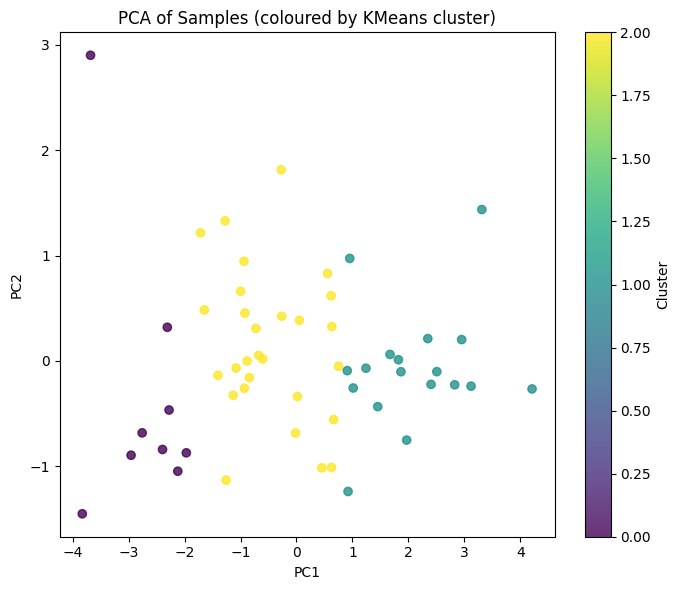

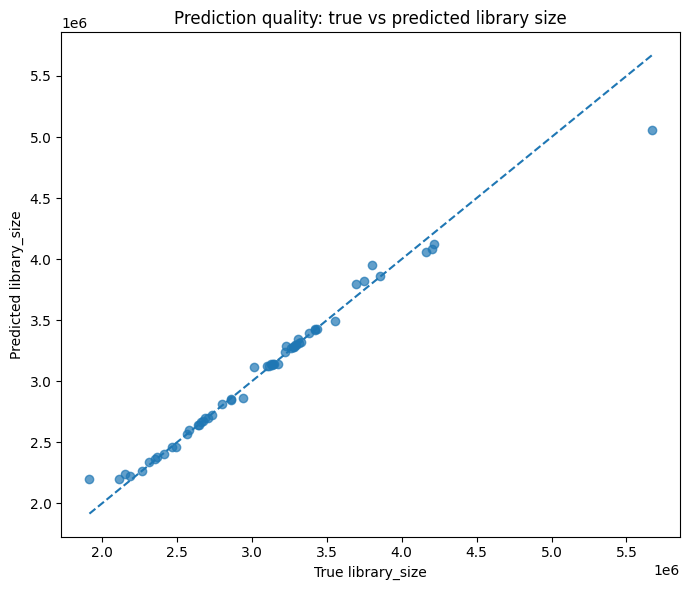

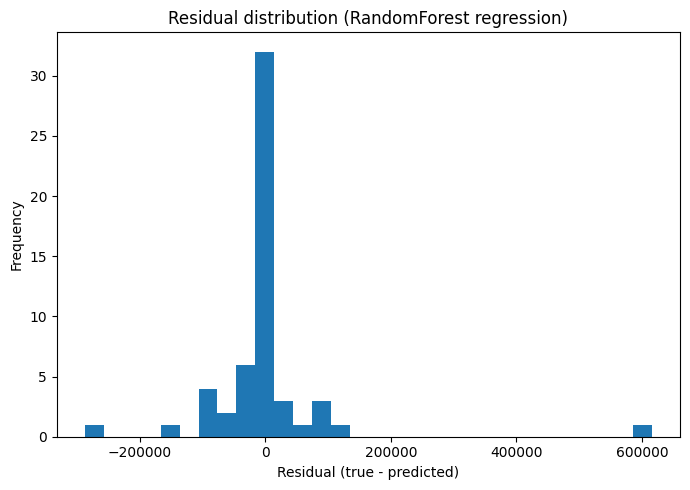

In [0]:
# =====================================================
# VISUALISATIONS: PCA, prediction quality, feature impact
# =====================================================

import matplotlib.pyplot as plt
import numpy as np

# If you're in a new cell & result_pdf is not in memory, uncomment this:
# result_pdf = result_spark.toPandas()

# 1) PCA scatter plot coloured by cluster
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    result_pdf["PC1"],
    result_pdf["PC2"],
    c=result_pdf["cluster"],
    cmap="viridis",
    alpha=0.8
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Samples (coloured by KMeans cluster)")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()

# 2) True vs predicted library size
plt.figure(figsize=(7, 6))
plt.scatter(
    result_pdf["target_library_size"],
    result_pdf["pred_library_size"],
    alpha=0.7
)

# 45-degree reference line
min_val = min(result_pdf["target_library_size"].min(),
              result_pdf["pred_library_size"].min())
max_val = max(result_pdf["target_library_size"].max(),
              result_pdf["pred_library_size"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("True library_size")
plt.ylabel("Predicted library_size")
plt.title("Prediction quality: true vs predicted library size")
plt.tight_layout()
plt.show()

# 3) Residuals histogram
residuals = result_pdf["target_library_size"] - result_pdf["pred_library_size"]

plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (true - predicted)")
plt.ylabel("Frequency")
plt.title("Residual distribution (RandomForest regression)")
plt.tight_layout()
plt.show()


In [0]:
# =========================================
# Cluster-level summary (Extra)
# =========================================
cluster_summary = (
    result_pdf
    .groupby("cluster")[["library_size", "avg_count", "pct_zero_genes"]]
    .agg(["mean", "std"])
)

cluster_summary


library_size                 ... pct_zero_genes          
                 mean            std  ...           mean       std
cluster                               ...                         
0        3.503231e+06  850020.747331  ...       0.609900  0.007324
1        2.539674e+06  367562.015391  ...       0.662286  0.010963
2        3.267319e+06  501661.563724  ...       0.635804  0.008172

[3 rows x 6 columns]

In [0]:
# =====================================
# Additional Regression Accuracy Metrics
# =====================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MODEL ACCURACY METRICS")
print("-----------------------")
print(f"R² Score:         {r2:.4f}")
print(f"MAE:              {mae:.2f}")
print(f"MSE:              {mse:.2f}")
print(f"RMSE:             {rmse:.2f}")
print(f"MAPE:             {mape:.2f}%")


MODEL ACCURACY METRICS
-----------------------
R² Score:         0.9719
MAE:              87294.95
MSE:              12837985974.22
RMSE:             113304.84
MAPE:             3.31%
